In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

# Dates
from datetime import datetime
from dateutil import parser

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio


py.init_notebook_mode(connected=True)

**Required for Plotly -- Run your first time through the notebook**

In [35]:
# !pip install jupyterlab "ipywidgets>=7.5"

In [23]:
# !jupyter labextension install jupyterlab-plotly@4.11.0

Building jupyterlab assets (build:prod:minimize)


In [3]:
# Import and update data types
df_timeseries = pd.read_csv("data/timeseries_with_tasks.csv", index_col = None,
                            dtype = {'pid': str,
                                     'episodeid': str,
                                     'providerpracticezipcode': str,
                                     'week_admit': str
                                    }
                           )

date_cols = ["week", "admit_week_start", "discharge_week_start", "admitdate", "dischargedate"]

for _ in date_cols:
    df_timeseries[_] = pd.to_datetime(df_timeseries[_])

In [84]:
# Adding Monthly Aggregation (just in case)
df_timeseries['work_month'] = (pd.to_datetime(df_timeseries['week']) - pd.tseries.offsets.MonthBegin(1)).astype(str)
df_timeseries['admit_month'] = pd.DatetimeIndex(df_timeseries['admitdate']).month.astype(str)

## Intial Exploration (Overall)

In [85]:
cols_to_keep = ['week', 'episodeid', 'week_admit', 'work_month', 'admit_month', 'pid', 'contracttype', 'county', 'onsite_hours', 'remote_hours']

In [86]:
# Drop columns unlikely to use. Making a new dataframe in case we need to revert later
df_eda1 = df_timeseries.drop(df_timeseries.columns.difference(cols_to_keep), 
                             axis = 1)

In [169]:
# Overall totals for all of texas
# Include two 'month' aggregations because there is a significant difference between calenadr week (work_month) and admit month (admit date)
df_group_week = df_eda1.groupby(by=['week']).sum()
df_group_month = df_eda1.groupby(by=['work_month']).sum()
df_group_admit_month = df_eda1.groupby(by=['admit_month']).sum()

In [170]:
# Include two 'month' aggregations because there is a significant difference between calendar week (work_month) and admit month (admit date)
df_group_admit_month = df_eda1[df_eda1['week'].dt.year != 2020]
df_group_admit_month = df_group_admit_month.groupby(by=['admit_month']).sum()

In [171]:
# Add total_hours column to both aggregations
df_group_week['total_hours'] = df_group_week['onsite_hours'] + df_group_week['remote_hours']
df_group_month['total_hours'] = df_group_month['onsite_hours'] + df_group_month['remote_hours']
df_group_admit_month['total_hours'] = df_group_admit_month['onsite_hours'] + df_group_admit_month['remote_hours']

In [178]:
# Test - Group by Week and County
df_group_week_tmp = df_eda1.groupby(by=['week', 'county']).sum().reset_index()
df_group_week_tmp = df_group_week_tmp.drop(['remote_hours'], axis = 1)

In [180]:
# Hours by County, By Week
df_weekly_county_hours = df_group_week_tmp.pivot_table(index=["week"], columns = 'county', values='onsite_hours')

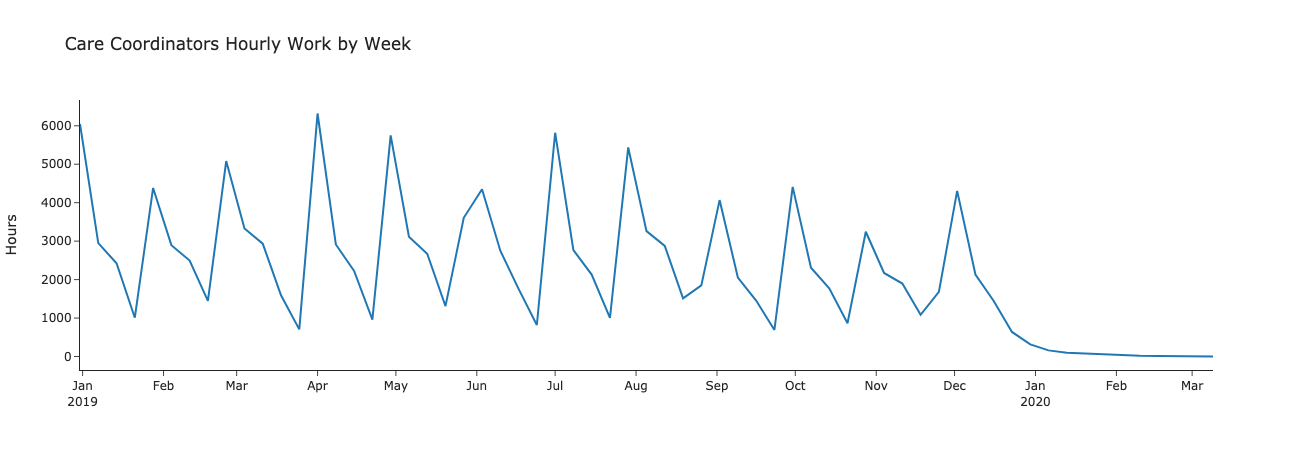

In [172]:
fig = px.line(df_group_week, 
              x = df_group_week.index.values, 
              y = df_group_week['total_hours'],
              title = "Care Coordinators\nHourly Work by Week",
              labels = {
                  'total_hours': 'Hours',
                  'x': ''
              },
              template = "simple_white"
)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")

fig.update_layout

fig.show();

In [173]:
# Tweaking to df_group_admit_month index to work better
df_group_admit_month.index = df_group_admit_month.index.astype(int)
df_group_admit_month.sort_index(inplace = True)
df_group_admit_month.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

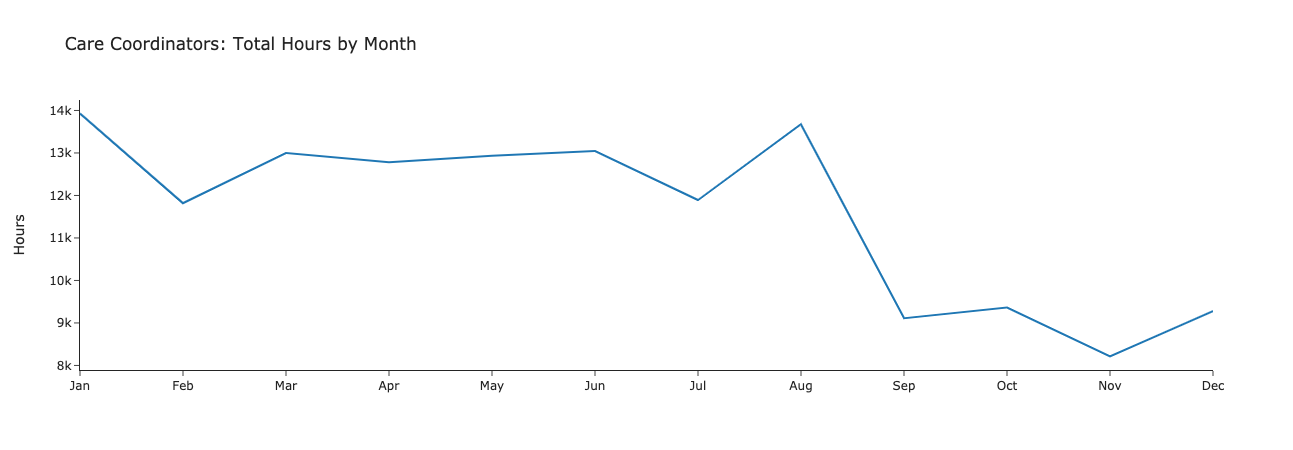

In [199]:
# df_group_admit_month.index = df_group_admit_month.index.map(str)
# df_group_admit_month = 

fig = px.line(df_group_admit_month, 
              x = df_group_admit_month.index.values, 
              y = df_group_admit_month['total_hours'],
              title = "Care Coordinators: Total Hours by Month",
              labels = {
                  'total_hours': 'Hours',
                  'x': ''
              },
              template = "simple_white",
)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")

fig.update_layout

fig.show();

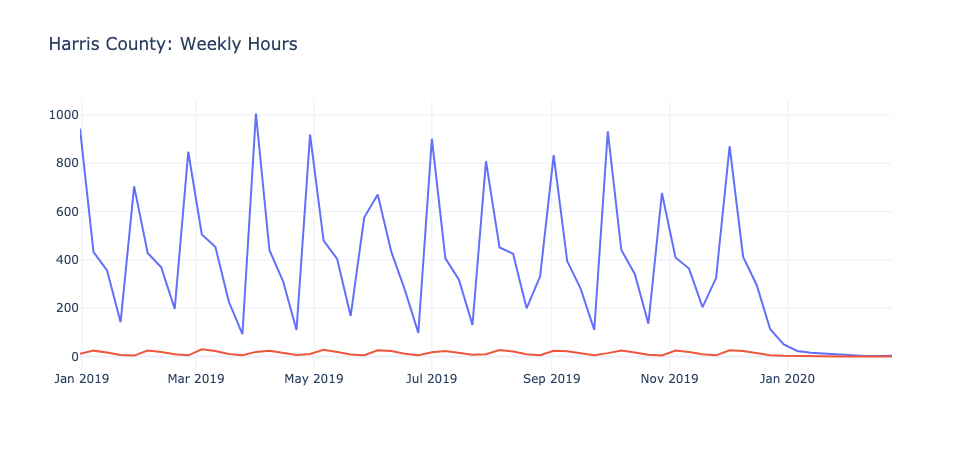

In [364]:
## Just looking at Harris County
data = df_eda1[df_eda1['county'] == 'Harris']
data = data.groupby(by=['week'], axis=0).sum()

fig = px.line(data, 
              x = data.index.values, 
              y = data.columns,
              title = "Harris County: Weekly Hours",
              template = "plotly_white",
              labels = dict(
                  y =  's',
                  x = 'Hours'
              )
 )
fig.update_layout(
    showlegend=False,
    xaxis_title = None,
    yaxis_title = None
)
fig.show();

Smoothing to a rolling 30 days to get a getter picture of overall changes in 'total hours'

Between the above visualizations and these, we see that there is a clear downward trending 'need' for CC's in terms of hours. The next questions we need to figure out will be

* Is this decreasing for a reason (fewer patients, length of stay, contract types, etc.)
* Where is this occuring. Is this across all of Texas or in specific counties?

In [300]:
df_rolling = df_eda1[['week', 'onsite_hours', 'remote_hours']].set_index('week').groupby('week').sum()
df_rolling = df_rolling.rolling("30D").sum()

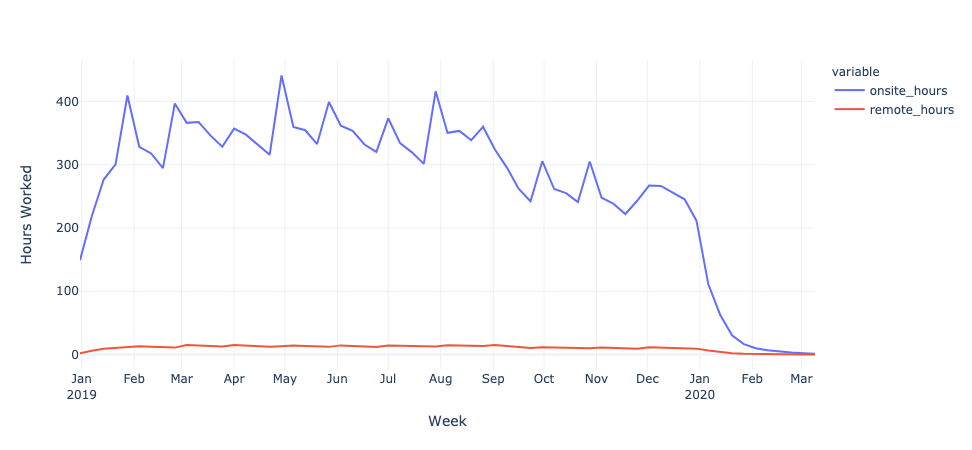

In [301]:
fig0 = px.line(df_rolling / 40, 
               x = df_rolling.index, 
               y = df_rolling.columns[0:2],
              template = "plotly_white")

fig0.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
)

fig0.update_layout(
    xaxis_title = 'Week',
    yaxis_title = 'Hours Worked'
)

fig0.show();

Week over Week Difference

In [323]:
df_group_week_diff = df_group_week.diff()
df_group_week_diff_pct = df_group_week.pct_change()

In [326]:
df_test = pd.DataFrame(data).reset_index()

In [327]:
df_test['negative'] = np.where(df_test['total_hours'] < 0, df_test['total_hours'], np.nan)
df_test['positive'] = np.where(df_test['total_hours'] >= 0, df_test['total_hours'], np.nan)

In [329]:
df_test.drop('total_hours', axis=1, inplace=True)
df_test.set_index('week', inplace=True)

In [343]:
df_test = df_test[['positive', 'negative']]

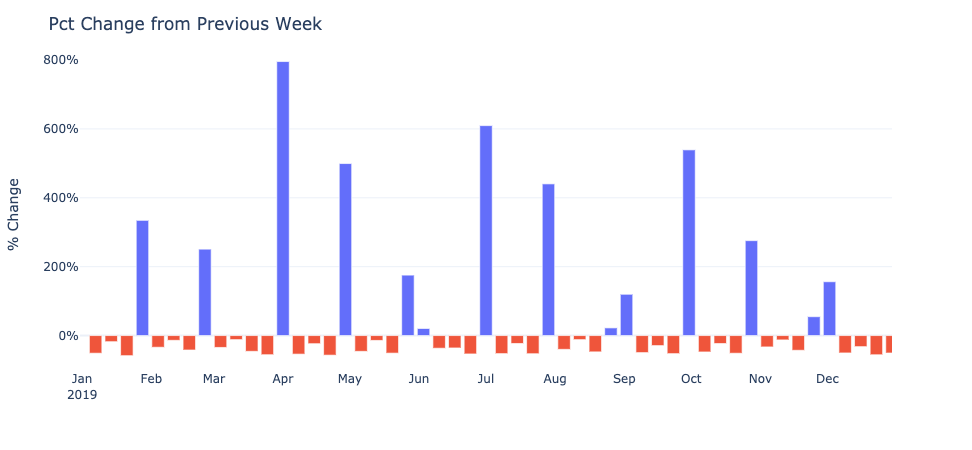

In [375]:
fig = px.bar(df_test, 
             x = df_test.index, 
             y = df_test.columns,
            template = "plotly_white"
)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
)

fig.update_yaxes(
    tickformat = ',.0%',
    range = [-1,8],
)

fig.update_layout(
    xaxis_title = None,
    yaxis_title = '% Change',
    title_text = 'Pct Change from Previous Week',
    xaxis_range = ['2018-12-31','2019-12-30'],
    barmode='relative',
    showlegend=False
)

fig.show();

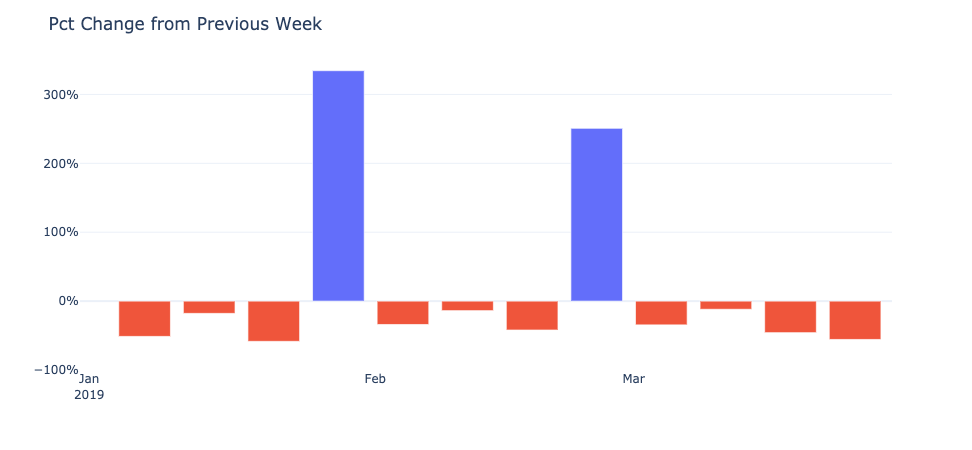

In [388]:
## Zoom in on the above
fig = px.bar(df_test, 
             x = df_test.index, 
             y = df_test.columns,
            template = "plotly_white"
)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
)

fig.update_yaxes(
    tickformat = ',.0%',
    range = [-1,3.5],
)

fig.update_layout(
    xaxis_title = None,
    yaxis_title = None,
    title_text = 'Pct Change from Previous Week',
    xaxis_range = ['2018-12-31','2019-03-29'],
    barmode='relative',
    showlegend=False
)

fig.show();

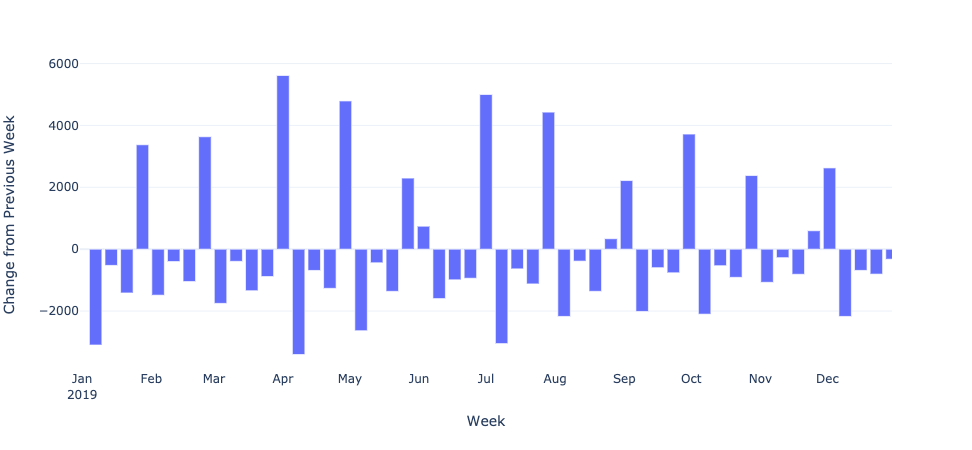

In [345]:
# TOTAL CHANGE
data = df_group_week_diff['total_hours']

fig = px.bar(data, 
             x = data.index, 
             y = data,
            template = "plotly_white"
)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
)

fig.update_layout(
    xaxis_title = 'Week',
    yaxis_title = 'Change from Previous Week',
    xaxis_range = ['2018-12-31','2019-12-30'],
    barmode='relative'
)

fig.show();

## Why -- Looking at why there is a drop in CC on-site needs
---

### Patient Volume

In [352]:
data = df_timeseries.loc[df_timeseries['week_admit'] == "1", ['admitdate', 'week_admit']]
data['week_admit'] = data['week_admit'].astype(int)
data = data.groupby(by=['admitdate']).agg('sum')

In [238]:
data = data.groupby(by=['work_month']).agg('sum').reset_index()

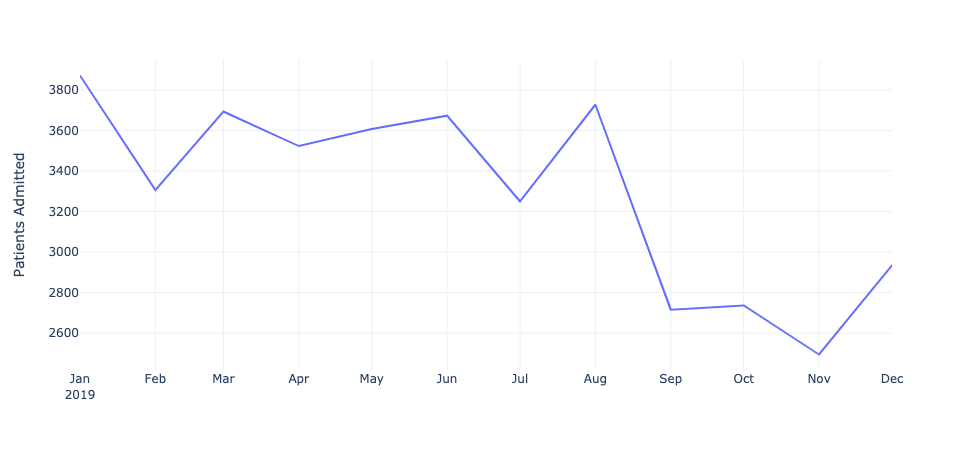

In [359]:
fig = px.line(data, 
              x = data.index, 
              y = data.columns,
              template = "plotly_white"
)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y"
)

fig.update_layout(
    showlegend=False,
    xaxis_title = None,
    yaxis_title = 'Patients Admitted',
)

fig.show()

## Number of SNFs in Each County

212 counties with 1244 SNFs -- Where are they all located?

In [441]:
df_snf_county = df_timeseries.drop_duplicates(subset=['pid'])[['pid', 'county']]

In [443]:
df_snf_county = df_snf_county.groupby('county').count().reset_index()

In [448]:
df_snf_county_25plus = df_snf_county.copy()

In [449]:
df_snf_county_25plus['pid'] = np.where(df_snf_county_25plus['pid'] >= 25, 25, df_snf_county_25plus['pid'])

In [450]:
df_snf_county.to_csv('map_data/snfs_per_county.csv', index=False)
df_snf_county_25plus.to_csv('map_data/snfs_per_county_25plus.csv', index=False)

### SNFs with a Patient (Jan-Mar)

In [432]:
df_snf_monthly = df_timeseries.drop_duplicates(subset=['pid','work_month'])[['work_month', 'pid']]

In [435]:
df_snf_monthly = df_snf_monthly.groupby('work_month').count()

In [455]:
df_snf_monthly['max_pid'] = 1244

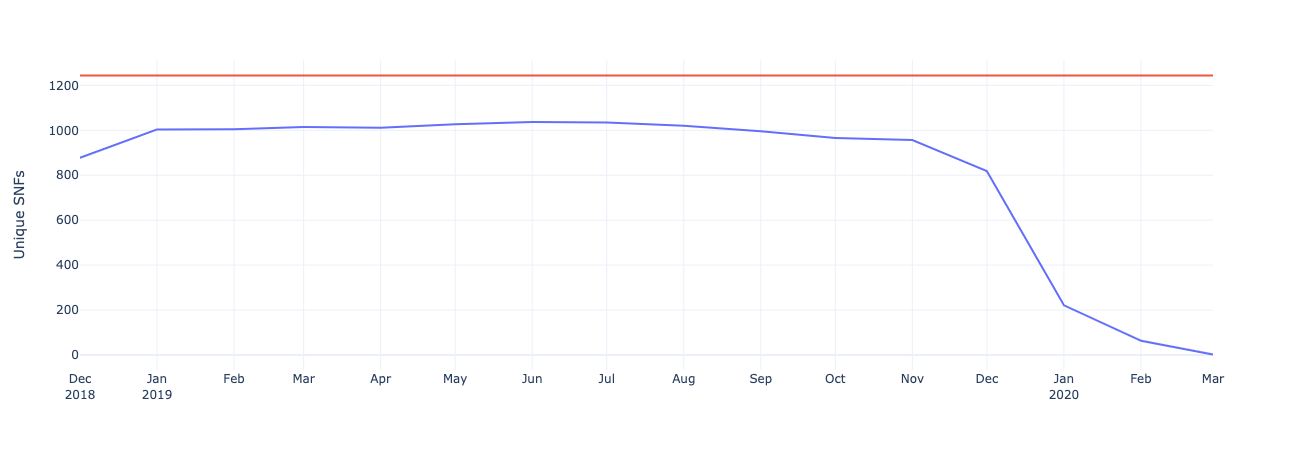

In [457]:
fig = px.line(df_snf_monthly, 
              x = df_snf_monthly.index, 
              y = df_snf_monthly.columns,
              template = "plotly_white"
)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y"
)

fig.update_layout(
    showlegend=False,
    xaxis_title = None,
    yaxis_title = 'Unique SNFs',
)

fig.show()

This is interesting -- What this shows is that month over month the # of unique SNFs changes. Let's show this as a change over time then figure out where they are happening

In [459]:
df_snf_monthly2 = df_snf_monthly['pid'].diff()

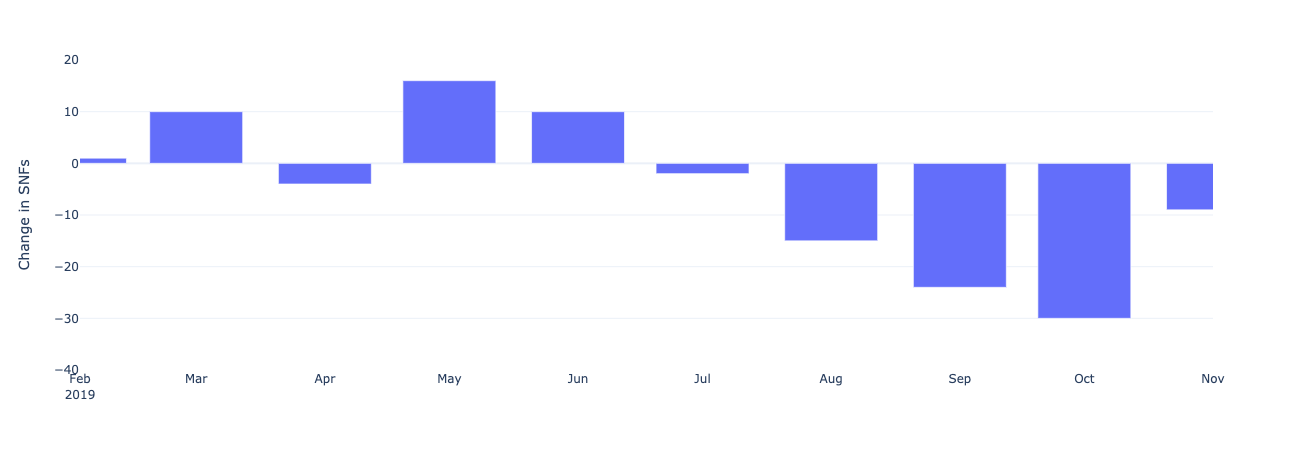

In [485]:
fig = px.bar(df_snf_monthly2, 
              x = df_snf_monthly2.index, 
              y = df_snf_monthly2.values,
              template = "plotly_white"
)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y"
)

fig.update_layout(
    showlegend=False,
    xaxis_title = None,
    yaxis_title = 'Change in SNFs',
    xaxis_range = ['2019-02-01','2019-11-01'],
    yaxis_range = [-40,20]
)

fig.show()

Getting the number of unique SNFs served, for each month, for each county. Including the full list of counties to make mapping easier

In [556]:
tx_counties = ["Anderson", "Andrews", "Angelina", "Aransas", "Archer", "Armstrong", "Atascosa", "Austin", "Bailey", "Bandera", "Bastrop", "Baylor", "Bee", "Bell", "Bexar", "Blanco", "Borden", "Bosque", "Bowie", "Brazoria", "Brazos", "Brewster", "Briscoe", "Brooks", "Brown", "Burleson", "Burnet", "Caldwell", "Calhoun", "Callahan", "Cameron", "Camp", "Carson", "Cass", "Castro", "Chambers", "Cherokee", "Childress", "Clay", "Cochran", "Coke", "Coleman", "Collin", "Collingsworth", "Colorado", "Comal", "Comanche", "Concho", "Cooke", "Coryell", "Cottle", "Crane", "Crockett", "Crosby", "Culberson", "Dallam", "Dallas", "Dawson", "Deaf Smith", "Delta", "Denton", "DeWitt", "Dickens", "Dimmit", "Donley", "Duval", "Eastland", "Ector", "Edwards", "Ellis", "El Paso", "Erath", "Falls", "Fannin", "Fayette", "Fisher", "Floyd", "Foard", "Fort Bend", "Franklin", "Freestone", "Frio", "Gaines", "Galveston", "Garza", "Gillespie", "Glasscock", "Goliad", "Gonzales", "Gray", "Grayson", "Gregg", "Grimes", "Guadalupe", "Hale", "Hall", "Hamilton", "Hansford", "Hardeman", "Hardin", "Harris", "Harrison", "Hartley", "Haskell", "Hays", "Hemphill", "Henderson", "Hidalgo", "Hill", "Hockley", "Hood", "Hopkins", "Houston", "Howard", "Hudspeth", "Hunt", "Hutchinson", "Irion", "Jack", "Jackson", "Jasper", "Jeff Davis", "Jefferson", "Jim Hogg", "Jim Wells", "Johnson", "Jones", "Karnes", "Kaufman", "Kendall", "Kenedy", "Kent", "Kerr", "Kimble", "King", "Kinney", "Kleberg", "Knox", "Lamar", "Lamb", "Lampasas", "La Salle", "Lavaca", "Lee", "Leon", "Liberty", "Limestone", "Lipscomb", "Live Oak", "Llano", "Loving", "Lubbock", "Lynn", "McCulloch", "McLennan", "McMullen", "Madison", "Marion", "Martin", "Mason", "Matagorda", "Maverick", "Medina", "Menard", "Midland", "Milam", "Mills", "Mitchell", "Montague", "Montgomery", "Moore", "Morris", "Motley", "Nacogdoches", "Navarro", "Newton", "Nolan", "Nueces", "Ochiltree", "Oldham", "Orange", "Palo Pinto", "Panola", "Parker", "Parmer", "Pecos", "Polk", "Potter", "Presidio", "Rains", "Randall", "Reagan", "Real", "Red River", "Reeves", "Refugio", "Roberts", "Robertson", "Rockwall", "Runnels", "Rusk", "Sabine", "San Augustine", "San Jacinto", "San Patricio", "San Saba", "Schleicher", "Scurry", "Shackelford", "Shelby", "Sherman", "Smith", "Somervell", "Starr", "Stephens", "Sterling", "Stonewall", "Sutton", "Swisher", "Tarrant", "Taylor", "Terrell", "Terry", "Throckmorton", "Titus", "Tom Green", "Travis", "Trinity", "Tyler", "Upshur", "Upton", "Uvalde", "Val Verde", "Van Zandt", "Victoria", "Walker", "Waller", "Ward", "Washington", "Webb", "Wharton", "Wheeler", "Wichita", "Wilbarger", "Willacy", "Williamson", "Wilson", "Winkler", "Wise", "Wood", "Yoakum", "Young", "Zapata", "Zavala"]

In [557]:
date_repeat = df_snf_monthly2.index.values[:12].repeat(len(tx_counties))
tx_counties = tx_counties * 12


In [558]:
df_base = pd.DataFrame({
    'month': date_repeat,
    'county': tx_counties
})

In [559]:
df_snf_county_month = df_timeseries.drop_duplicates(subset=['pid', 'county', 'work_month'])[['pid', 'county', 'work_month']]

In [560]:
df_snf_county_month = df_snf_county_month.groupby(by=['work_month', 'county'], axis = 0).count().reset_index()

In [561]:
df_snf_county_month = df_base.merge(
    right = df_snf_county_month,
    how ='left', 
    left_on = ['month', 'county'],
    right_on = ['work_month', 'county']
)

In [562]:
df_snf_county_month.loc[df_snf_county_month['pid'].isna(), 'pid'] = 0
df_snf_county_month = df_snf_county_month.drop('work_month', axis = 1)

In [564]:
# df_snf_county_month.to_csv('map_data/county_snf_count_monthly.csv', index=False)

### Do it Again -- Now for Episodes

In [571]:
df_episode_county_month = df_timeseries.drop_duplicates(subset=['episodeid', 'county', 'work_month'])[['episodeid', 'county', 'work_month']]
df_episode_county_month = df_episode_county_month.groupby(by=['work_month', 'county'], axis = 0).count().reset_index()

In [572]:
df_episode_county_month = df_base.merge(
    right = df_episode_county_month,
    how ='left', 
    left_on = ['month', 'county'],
    right_on = ['work_month', 'county']
)

In [574]:
df_episode_county_month.loc[df_episode_county_month['episodeid'].isna(), 'episodeid'] = 0
df_episode_county_month = df_episode_county_month.drop('work_month', axis = 1)

In [583]:
df_county_month =  df_snf_county_month.merge(df_episode_county_month, 
                                             how = 'inner', 
                                             on = ['month', 'county'])

In [584]:
df_county_month

,month,county,pid,episodeid
0,2018-12-01,Anderson,2.0,5.0
1,2018-12-01,Andrews,0.0,0.0
2,2018-12-01,Angelina,6.0,22.0
3,2018-12-01,Aransas,2.0,2.0
4,2018-12-01,Archer,0.0,0.0
...,...,...,...,...
3043,2019-11-01,Wood,2.0,2.0
3044,2019-11-01,Yoakum,2.0,2.0
3045,2019-11-01,Young,2.0,5.0
3046,2019-11-01,Zapata,1.0,1.0


In [587]:
df_county_month = df_county_month.rename({
    'pid': 'count_pid',
    'episodeid': 'count_episodeid',
})

In [588]:
df_county_month.to_csv('map_data/county_count_monthly.csv', index=False)

## Where
---

Looking at where patient intake dropped

In [219]:
data2 = df_eda1.loc[df_eda1['week_admit'] == 1, ['week', 'county', 'onsite_hours']]

In [220]:
data2

,week,county,onsite_hours


In [448]:
data2 = data2.groupby(by=['week', 'county']).agg(['sum', 'max', 'mean']).reset_index()

In [450]:
data2[data2['county'] == 'Harris']

month  county onsite_hours                
                                 sum   max      mean
65   2018-12-01  Harris       943.84  2.71  1.602445
227  2019-01-01  Harris       641.22  1.92  1.264734
394  2019-02-01  Harris       764.42  1.92  1.263504
566  2019-03-01  Harris       953.62  2.71  1.708996
732  2019-04-01  Harris       849.81  2.71  1.504088
903  2019-05-01  Harris       493.57  1.92  0.861379
1078 2019-06-01  Harris       849.25  2.71  1.722617
1238 2019-07-01  Harris       742.26  2.71  1.356965
1406 2019-08-01  Harris       235.92  1.92  0.430511
1570 2019-09-01  Harris       878.63  2.71  1.645375
1733 2019-10-01  Harris       608.23  1.92  1.267146
1901 2019-11-01  Harris       249.51  1.92  0.434686

In [413]:
data2 = data2.pivot_table(index=["month"], columns = 'county', values='onsite_hours')

In [414]:
data2.index.get_level_values(0)

DatetimeIndex(['2018-12-31', '2019-01-28', '2019-02-25', '2019-04-01',
               '2019-04-29', '2019-05-27', '2019-07-01', '2019-07-29',
               '2019-08-26', '2019-09-30', '2019-10-28', '2019-11-25'],
              dtype='datetime64[ns]', name='week', freq=None)

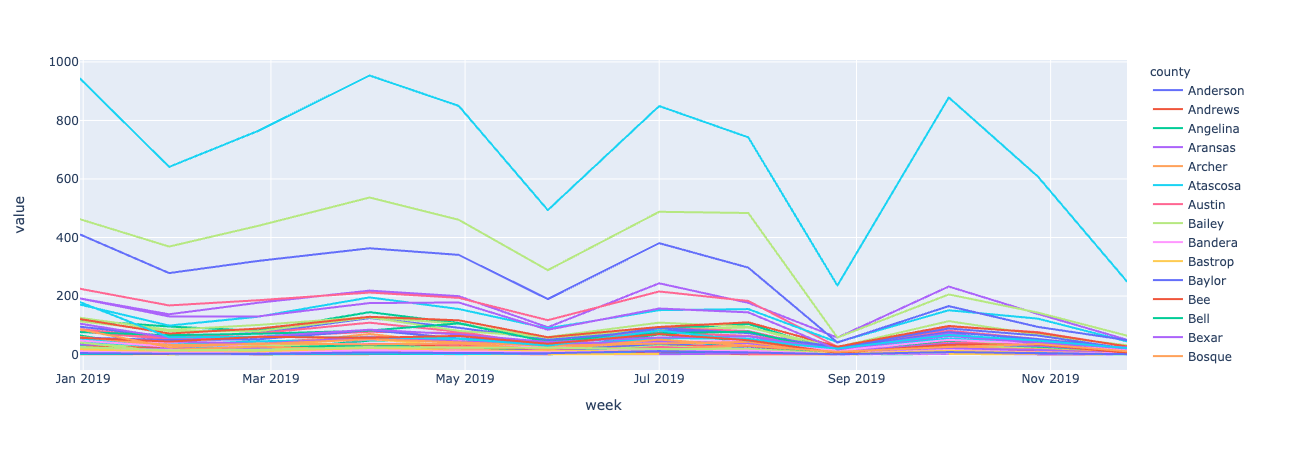

In [418]:
fig = px.line(data2, 
              x = data2.index.get_level_values(0), 
              y = data2.columns)

# fig.update_xaxes(
#     dtick="M1",
#     tickformat="%b\n%Y",
# )

fig.show()

In [400]:
data2

county,Anderson,Andrews,Angelina,Aransas,Archer,Atascosa,Austin,Bailey,Bandera,Bastrop,...,Wilbarger,Willacy,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata
month,,,,,,,,,,,,,,,,,,,,,
2018-12-01,5.0,NaN,22.0,2.0,NaN,10.0,2.0,1.0,1.0,12.0,...,1.0,3.0,54.0,3.0,1.0,16.0,5.0,NaN,3.0,NaN
2019-01-01,16.0,NaN,25.0,4.0,NaN,6.0,1.0,1.0,NaN,5.0,...,2.0,5.0,21.0,6.0,NaN,11.0,5.0,1.0,2.0,NaN
2019-02-01,10.0,NaN,17.0,3.0,NaN,9.0,2.0,1.0,1.0,10.0,...,2.0,7.0,33.0,3.0,NaN,13.0,3.0,2.0,2.0,NaN
2019-03-01,5.0,NaN,20.0,4.0,NaN,4.0,NaN,NaN,NaN,10.0,...,2.0,4.0,21.0,6.0,1.0,14.0,8.0,NaN,4.0,NaN
2019-04-01,12.0,NaN,17.0,5.0,NaN,7.0,2.0,2.0,1.0,10.0,...,NaN,2.0,29.0,2.0,NaN,14.0,6.0,NaN,3.0,NaN
2019-05-01,4.0,1.0,25.0,1.0,NaN,5.0,1.0,NaN,NaN,10.0,...,2.0,4.0,22.0,7.0,1.0,27.0,9.0,1.0,5.0,NaN
2019-06-01,6.0,NaN,40.0,1.0,NaN,3.0,NaN,1.0,3.0,8.0,...,1.0,1.0,33.0,1.0,NaN,11.0,6.0,1.0,6.0,NaN
2019-07-01,12.0,NaN,37.0,7.0,NaN,11.0,1.0,NaN,1.0,13.0,...,3.0,5.0,23.0,NaN,1.0,13.0,9.0,NaN,5.0,NaN
2019-08-01,6.0,NaN,16.0,3.0,NaN,4.0,1.0,1.0,2.0,13.0,...,1.0,1.0,26.0,5.0,1.0,1.0,1.0,NaN,2.0,NaN
